In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler              #for standardising 
from sklearn.model_selection import train_test_split          #for spliting test and train data
from sklearn.preprocessing import MinMaxScaler                #for standardising y (1s and 0s) for classification
from sklearn.metrics import accuracy_score                    # fir evauation
import math
from tqdm import tqdm_notebook
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

In [33]:
!ls

mobile_cleaned.csv  sample_data


In [34]:
data=pd.read_csv("mobile_cleaned.csv")

In [35]:
data.head()

,PhoneId,Pixel Density,Screen Size,Weight,RAM,Processor_frequency,Screen to Body Ratio (calculated),Height,Internal Memory,Capacity,Resolution,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,...,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Rating
0,0,403,6.26,182,4,1.8,80.68,157.9,64,4000,20,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.5
1,1,271,6.20,168,3,1.8,80.85,156.2,32,4230,8,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.5
2,2,409,6.30,168,3,2.1,83.68,157.0,32,3500,25,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.4
3,4,411,6.00,169,4,2.2,74.78,159.8,64,3300,24,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,4.3
4,5,396,6.50,175,4,2.2,84.23,160.4,64,3750,16,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.4


In [36]:
x=data.drop('Rating',axis=1)
y=data['Rating']

In [37]:
y.head()

0    4.5
1    4.5
2    4.4
3    4.3
4    4.4
Name: Rating, dtype: float64

In [38]:
y=y.values

In [39]:
threshold=4.2
data['Class']=(data['Rating']>=threshold).astype(np.int)    #boolean to int

In [40]:
data['Class'].head()

0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64

In [41]:
y_binarised=data['Class'].values

## spliting test and train data for x,y

In [42]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0, stratify=y_binarised)

1. random_state is for same split every time you run the code
2. stratify a catogorical variable will ensure that the number of 1s and 0s in x_train and x_test are roughly the same

## Standardising x and y
$z_i=\frac{x_i-\mu}{s}$ where $\mu$ is mean and s is standard deviation 

1. we are allowed to standardise train data by computing train data mean and SD
2. we are not allowed to standardise the test data by computing test data mean and SD
3. we should fit the mean and SD of 'train data' on a scaler and transform both train and test data

In [43]:
scaler=StandardScaler()

In [44]:
x_scaled_train=scaler.fit_transform(x_train)   # fit and transform based on x_train
x_scaled_test=scaler.transform(x_test)          # transform based on x_train

In [45]:
print(np.mean(x_scaled_train),np.std(x_scaled_train),np.min(x_scaled_train),np.max(x_scaled_train)) #mean close to 0, std close to 1

-3.611164906781668e-17 0.9589266029707683 -5.496174680190546 15.937377450509228


## standardising y (classification purpose)
1. it should match the characteristics of sigmoid curve (i.e. minimum number should be 0 and the maximum number should be 1) 

In [46]:
minmax_scaler=MinMaxScaler()

In [47]:
y_scaled_train=minmax_scaler.fit_transform(y_train.reshape(-1,1)) #data only have one feature so reshaping (-1,1)
y_scaled_test=minmax_scaler.transform(y_test.reshape(-1,1)) 

In [48]:
print(np.min(y_scaled_train), np.max(y_scaled_train))


0.0 1.0


transforming threshold value for binarising the y for classification purpose

In [49]:
scaled_threshold=minmax_scaler.transform(np.array([threshold]).reshape(-1,1))
scaled_threshold=list(scaled_threshold)[0][0]

In [50]:
scaled_threshold

0.6800000000000002

binarising the scaled_y

In [51]:
y_binarised_train=(y_scaled_train>scaled_threshold).astype(np.int).ravel() #ravel for making a single 1d array
y_binarised_test=(y_scaled_test>scaled_threshold).astype(np.int).ravel() 

In [52]:
class SigmoidNeuron:
  def __init__(self):
    self.w=None                               
    self.b=None
  def perceptron(self,x):                        #perceptron---> because sigmoid have 1/(1+e^-(perceptron))
    return np.dot(x,self.w.T)+self.b

  def sigmoid(self,x):                           #sigmoid function
    return 1.0/(1.0+np.exp(-x)) 

  def grad_w(self,x,y):                          #gradient of w  del(w)  #for w=w+del_w 
    y_pred=self.sigmoid(self.perceptron(x))
    if y==0:
      return y_pred*x
    elif y==1:
      return -1*(1-y_pred)*x
    else:
      raise ValueError("y should be 0 or 1")

  def grad_b(self,x,y):                          #gradient of b  del(b)  #for b=b+del_b 
    y_pred=self.sigmoid(self.perceptron(x))
    if y==0:
      return y_pred
    elif y==1:
      return -1*(1-y_pred)
    else:
      raise ValueError("y should be 0 or 1")


  def fit(self,x,y,epochs=1,learning_rate=1,initialise=True,display_loss=False):     # learning algorithm of sigmoid  # refer sigmoid notes for clarity
    #initialise w, b
    if initialise:
      self.w=np.random.randn(1,x.shape[1])               # since w is a vector which should be in the shape of x
      self.b=0 
                                                # since b is a scalar
    if display_loss:                            # for loss plot
      loss={}

    for i in tqdm_notebook(range(epochs),total=epochs,unit="epoch"):   # tqdm_notebook shows the time(in output terminal) for each epoch to be completed 
      dw=0
      db=0
      for X,Y in zip(x,y):                       # gradient is found for all values present x and y vectors          
        dw += self.grad_w(X,Y)
        db += self.grad_b(X,Y)
      self.w -= learning_rate*dw                 # learning rate is multiplied for w(vector) and b(scalar)
      self.b -= learning_rate*db
      
      if display_loss:
        y_pred=self.sigmoid(self.perceptron(x))
        loss[i]=log_loss(y,y_pred)             #(-((1-y)*math.log(1-y_pred,2)+y*math.log(y_pred,2)))         #mean_squared_error(y_pred,y)
    
    if display_loss:                                  # for loss plot
      plt.plot(list(loss.values()))                   # plot is not calable for dict values so we convert it into list
      plt.xlabel('Epochs')
      plt.ylabel('cross entropy loss function')

  def predict(self,x):                                 # for testing 
    y_pred=[]
    for i in x:
      yy_pred=self.sigmoid(self.perceptron(i))
      y_pred.append(yy_pred)
    return np.array(y_pred)

In [53]:
sn=SigmoidNeuron()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


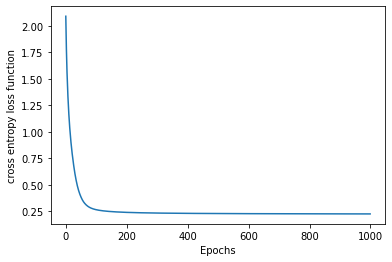

In [54]:
sn.fit(x_scaled_train,y_binarised_train,epochs=1000,learning_rate=0.0015,display_loss=True)

In [55]:
y_pred_train=sn.predict(x_scaled_train)
y_pred_test=sn.predict(x_scaled_test)

In [56]:
y_pred_binarised_train=(y_pred_train>scaled_threshold).astype(np.int).ravel()
y_pred_binarised_test=(y_pred_test>scaled_threshold).astype(np.int).ravel()

In [57]:
accuracy_train=accuracy_score(y_pred_binarised_train,y_binarised_train)
accuracy_test=accuracy_score(y_pred_binarised_test,y_binarised_test)

In [58]:
print("train accuracy: ",accuracy_train,"\ntest accuracy: ",accuracy_test)

train accuracy:  0.8823529411764706 
test accuracy:  0.8023255813953488
